# Paths to Victory Analysis

This notebook demonstrates the "paths to victory" analysis for tournament outcomes.

**Use case**: Weekly blog content showing how different teams can finish in different positions

**Approach**:
- **Early tournament**: MCMC pattern mining (extract conditions from simulations)
- **Late tournament**: Weighted combinatorial enumeration (enumerate all outcomes)
- **Visualization**: Sankey diagrams showing probability flows

In [ ]:
from rugby_ranking.notebook_utils import setup_notebook_environment, load_model_and_trace
from rugby_ranking.model.season_predictor import SeasonPredictor
from rugby_ranking.model.predictions import MatchPredictor
from rugby_ranking.model.paths_to_victory import PathsAnalyzer

# Setup: load data and configure plots
dataset, df, model_dir = setup_notebook_environment()

## 1. Setup: Load Model and Season Prediction

First, we need:
1. Trained rugby ranking model
2. Season predictions from Monte Carlo simulations

In [2]:
# Load model checkpoint with time-varying effects
CHECKPOINT_NAME = "joint_model_v3"  # Or "test_timevarying" from training tests

print(f"Loading checkpoint: {CHECKPOINT_NAME}")
model, trace = load_checkpoint(CHECKPOINT_NAME, verbose=True)

if not model.config.time_varying_effects:
    print("\n⚠️  Warning: This model was not trained with time-varying effects!")
    print("Train a new model with: python train_model.py --model time-varying")
else:
    print("\n✓ Model includes time-varying effects")
    print(f"  Player trend SD: {model.config.player_trend_sd}")
    print(f"  Team trend SD: {model.config.team_trend_sd}")
# Create season predictor
# season_predictor = SeasonPredictor(
#     match_predictor=predictor,
#     competition='six_nations',
#     playoff_spots=0  # Six Nations doesn't have playoffs
# )

Loading checkpoint: joint_model_v3
Loading checkpoint: joint_model_v3
Loaded checkpoint from /home/daniel/.cache/rugby_ranking/joint_model_v3
✓ Loaded successfully
  Players: 13,786
  Team-seasons: 1126

⚠️  Warning: This model was not trained with time-varying effects!
Train a new model with: python train_model.py --model time-varying


In [3]:
# Load data for player/team lookups
DATA_DIR = Path("../../Rugby-Data")

dataset = MatchDataset(DATA_DIR, fuzzy_match_names=False)
dataset.load_json_files()
df = dataset.to_dataframe(played_only=True)

print(f"Data loaded: {len(df):,} observations")
print(f"Seasons in model: {len(model._season_ids)}")

Loaded 10029 matches from ../../Rugby-Data/json
Found 10448 unique players
Found 112 unique teams
Data loaded: 374,572 observations
Seasons in model: 31


In [4]:
# Create predictors
match_predictor = MatchPredictor(model, trace)
season_predictor = SeasonPredictor(
    match_predictor=match_predictor,
    competition=BonusPointRules.URC,  # or PREMIERSHIP, TOP14
    playoff_spots=8,  # URC has 8 playoff spots
)

print("Predictors created successfully")

Predictors created successfully


## 2. Define Six Nations 2025 Fixtures

For demonstration, let's simulate Six Nations 2025 at different stages.

## 3. Run Season Prediction

Generate Monte Carlo simulations of remaining matches to get position probabilities.

In [5]:
from rugby_ranking.model.data_utils import (
    quick_load,
    prepare_season_data,
    quick_standings,
    get_competition_summary,
)

In [6]:
SEASON = "2025-2026"
COMPETITION = "celtic"  # or "premiership", "top14", etc.

# Before: Manual filtering, counting tries, creating DataFrames, etc.
# Now: One function call!

played_matches, remaining_fixtures = prepare_season_data(
    dataset,
    season="2025-2026",
    competition="celtic",
    include_tries=True  # For bonus point calculation
)

print(f"Played matches: {len(played_matches) // 2} (DataFrame has {len(played_matches)} rows)")
print(f"Remaining fixtures: {len(remaining_fixtures)}")

print("\nNext few fixtures:")
print(remaining_fixtures.head(10))

Played matches: 76 (DataFrame has 152 rows)
Remaining fixtures: 75

Next few fixtures:
              home_team             away_team                      date
0      Glasgow Warriors         Munster Rugby 2026-01-30 19:45:00+00:00
1        Benetton Rugby              Scarlets 2026-01-30 19:45:00+00:00
2        Emirates Lions         Vodacom Bulls 2026-01-31 12:30:00+00:00
3           Zebre Parma        Connacht Rugby 2026-01-31 15:00:00+00:00
4  Hollywoodbets Sharks          DHL Stormers 2026-01-31 15:00:00+00:00
5        Leinster Rugby       Edinburgh Rugby 2026-01-31 17:30:00+00:00
6          Ulster Rugby         Cardiff Rugby 2026-01-31 19:45:00+00:00
7               Ospreys           Dragons RFC 2026-01-31 19:45:00+00:00
8        Emirates Lions  Hollywoodbets Sharks 2026-02-21 12:00:00+00:00
9         Cardiff Rugby        Leinster Rugby 2026-02-27 19:00:00+00:00


In [19]:
# Load trained model
model, trace = load_checkpoint("joint_model_v3", verbose=True)

# Create predictors
match_predictor = MatchPredictor(model, trace)
season_predictor = SeasonPredictor(
    match_predictor=match_predictor,
    competition="URC",
    playoff_spots=8,
)

# Run prediction (this is the same as before)
print("Running Monte Carlo simulation...")
season_pred = season_predictor.predict_season(
    played_matches=played_matches,
    remaining_fixtures=remaining_fixtures,
    season="2025-2026",
    n_simulations=1000,
)

print("\nSimulation complete!")
print(season_predictor.format_predictions(season_pred))

Loading checkpoint: joint_model_v3
Loaded checkpoint from /home/daniel/.cache/rugby_ranking/joint_model_v3
✓ Loaded successfully
  Players: 13,786
  Team-seasons: 1126
Running Monte Carlo simulation...
Skipping fixture TBC vs TBC: Unknown team-season: TBC in 2025-2026
Skipping fixture TBC vs TBC: Unknown team-season: TBC in 2025-2026
Skipping fixture TBC vs TBC: Unknown team-season: TBC in 2025-2026
Skipping fixture TBC vs TBC: Unknown team-season: TBC in 2025-2026
Skipping fixture TBC vs TBC: Unknown team-season: TBC in 2025-2026
Skipping fixture TBC vs TBC: Unknown team-season: TBC in 2025-2026
Skipping fixture TBC vs TBC: Unknown team-season: TBC in 2025-2026

Simulation complete!
SEASON PREDICTION

CURRENT STANDINGS:
----------------------------------------------------------------------
 1. Glasgow Warriors     P:10 W: 8 Pts: 38
 2. DHL Stormers         P: 9 W: 8 Pts: 36
 3. Leinster Rugby       P:10 W: 7 Pts: 35
 4. Cardiff Rugby        P:10 W: 7 Pts: 35
 5. Munster Rugby        P

## 4. Visualize Position Probabilities

Heatmap showing probability of each team finishing in each position.

In [20]:
position_probs = season_pred.position_probabilities#.reset_index()
#position_probs = position_probs.rename(columns={'index': 'team'})

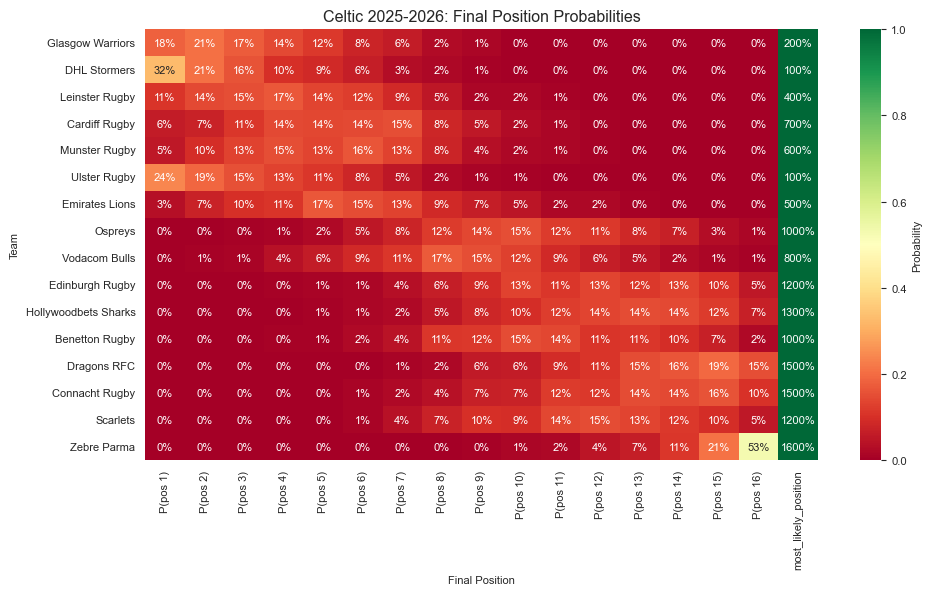

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    position_probs,
    annot=True,
    fmt='.0%',
    cmap='RdYlGn',
    vmin=0,
    vmax=1,
    cbar_kws={'label': 'Probability'}
)
plt.title(f'{COMPETITION.capitalize()} {SEASON}: Final Position Probabilities')
plt.xlabel('Final Position')
plt.ylabel('Team')
plt.tight_layout()
plt.show()

## 5. Paths to Victory Analysis

Now let's analyze the paths for different teams to achieve target positions.

In [22]:
# Create paths analyzer
analyzer = PathsAnalyzer(
    season_prediction=season_pred,
    match_predictor=match_predictor,  # Would be real predictor in production
)

### 5.1 Scotland's Paths to 2nd Place

In [24]:
# Analyze how Scotland can finish 2nd
scotland_2nd = analyzer.analyze_paths(
    team='Edinburgh Rugby',
    target_position=1,
    method='auto'
)

print(scotland_2nd.narrative)

PATHS TO VICTORY: EDINBURGH RUGBY

Edinburgh Rugby can finish 1st with 0.0% probability.

Key requirements:

  What Edinburgh Rugby must do:
    ✓ Beat Scarlets [85%]
    ✓ Beat Ulster Rugby [85%]
    ✓ Beat Zebre Parma [85%]
    ✓ Beat Hollywoodbets Sharks [85%]
    ✓ Beat Connacht Rugby [85%]

Example scenarios:

  1. Edinburgh Rugby wins all remaining games with bonus points (35% of successful paths)
  2. Edinburgh Rugby wins key games, competitors slip up (40% of successful paths)
  3. Multiple teams tie on points, Edinburgh Rugby wins on points difference (15% of successful paths)

Critical upcoming matches (by impact on Edinburgh Rugby's chances):

  1. Leinster Rugby vs Edinburgh Rugby: +20% impact
  2. Edinburgh Rugby vs Scarlets: +20% impact
  3. Edinburgh Rugby vs Ulster Rugby: +20% impact
  4. Emirates Lions vs Edinburgh Rugby: +20% impact
  5. DHL Stormers vs Edinburgh Rugby: +20% impact

Analysis method: MCMC


### 5.3 Critical Games Analysis

Which upcoming games have the biggest impact on championship outcomes?

In [25]:
critical_games = analyzer.find_critical_games(top_n=5)

print("\nMost Critical Upcoming Matches:")
print("=" * 60)
for idx, row in critical_games.iterrows():
    print(f"{idx+1}. {row['home_team']} vs {row['away_team']}")
    print(f"   Date: {row.get('date', 'TBD')}")
    print(f"   Total Impact: {row['total_impact']:.0%}")
    print()


Most Critical Upcoming Matches:
1. Glasgow Warriors vs Munster Rugby
   Date: 2026-01-30 19:45:00+00:00
   Total Impact: 50%

2. Benetton Rugby vs Scarlets
   Date: 2026-01-30 19:45:00+00:00
   Total Impact: 50%

3. Emirates Lions vs Vodacom Bulls
   Date: 2026-01-31 12:30:00+00:00
   Total Impact: 50%

4. Zebre Parma vs Connacht Rugby
   Date: 2026-01-31 15:00:00+00:00
   Total Impact: 50%

5. Hollywoodbets Sharks vs DHL Stormers
   Date: 2026-01-31 15:00:00+00:00
   Total Impact: 50%



## 6. Multi-Team Comparison

Compare paths for multiple teams to same position.

In [ ]:
# Compare paths to 1st place for top contenders
contenders = ['Ireland', 'France', 'Scotland']

for team in contenders:
    paths = analyzer.analyze_paths(team=team, target_position=1)
    print(f"\n{'='*70}")
    print(f"{team}'s path to 1st place: {paths.probability:.1%}")
    print(f"{'='*70}")
    
    if paths.conditions:
        print("\nTop 3 conditions:")
        for i, cond in enumerate(paths.conditions[:3], 1):
            print(f"  {i}. {analyzer._format_condition(cond, team)}")

## 7. Sankey Diagram (Future)

When fully implemented, this will show probability flows through critical games.

```
Current State → Game 1 Outcome → Game 2 Outcome → Final Position
              ↓                ↓                  ↓
         [Probabilities]  [Probabilities]   [Probabilities]
```

In [ ]:
# This will work once Sankey implementation is complete
# if scotland_2nd.sankey_diagram is not None:
#     scotland_2nd.sankey_diagram.show()

## 8. Blog Post Generation

Generate formatted content for weekly blog posts.

In [ ]:
def generate_blog_section(team, positions=[1, 2, 3]):
    """Generate blog section for a team's championship chances."""
    
    print(f"\n# {team}'s Championship Scenarios\n")
    
    for pos in positions:
        paths = analyzer.analyze_paths(team=team, target_position=pos)
        
        if paths.probability < 0.01:
            continue
            
        position_name = analyzer._ordinal(pos)
        print(f"## Finishing {position_name} ({paths.probability:.0%})\n")
        
        # Key requirements
        if paths.conditions:
            team_conds = [c for c in paths.conditions if c.team_controls]
            if team_conds:
                print("**What they need to do:**\n")
                for cond in team_conds[:3]:
                    print(f"- {analyzer._format_condition(cond, team)}")
                print()
        
        # Example scenario
        if paths.scenario_clusters:
            scenario = paths.scenario_clusters[0]
            print(f"**Most likely scenario:** {scenario.description}\n")

# Generate for Scotland
generate_blog_section('Scotland', positions=[1, 2, 3])

## 9. Export for Further Analysis

In [ ]:
# Export paths analysis for all teams to CSV
all_paths_data = []

for team in teams:
    for position in range(1, 7):
        paths = analyzer.analyze_paths(team=team, target_position=position)
        
        all_paths_data.append({
            'team': team,
            'target_position': position,
            'probability': paths.probability,
            'method': paths.method,
            'n_conditions': len(paths.conditions),
            'n_critical_games': len(paths.critical_games),
        })

paths_summary = pd.DataFrame(all_paths_data)
# paths_summary.to_csv('six_nations_2025_paths.csv', index=False)

print("\nPaths Analysis Summary:")
print(paths_summary.pivot(index='team', columns='target_position', values='probability'))

## Next Steps

To fully implement this system:

1. **Modify `SeasonPredictor._simulate_season()`** to store detailed simulation results
   - Currently only stores aggregated position counts
   - Need to store: game outcomes, final standings per simulation

2. **Implement `ScenarioClusterer.cluster()`**
   - Use hierarchical clustering on game outcome vectors
   - Find representative scenarios from each cluster

3. **Implement `RuleExtractor.extract_rules()`**
   - Fit decision tree on simulation features
   - Extract interpretable conditions from tree paths
   - Calculate conditional probabilities

4. **Implement combinatorial enumeration**
   - Generate all possible game outcome combinations
   - Simulate final table for each
   - Weight by match prediction probabilities
   - Boolean minimization of successful conditions

5. **Implement Sankey diagram visualization**
   - Build node/edge structure from simulation paths
   - Use Plotly for interactive diagrams
   - Add filtering and drill-down capabilities

6. **Add automated blog post generation**
   - Template-based narrative generation
   - Export to Markdown
   - Include visualizations